In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.

In [2]:
embedding_layer = layers.Embedding(1000, 5)

When you create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer). During training, they are gradually adjusted via backpropagation

In [3]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[ 0.01109147, -0.00987475,  0.04052318, -0.00840271,  0.02017396],
       [-0.00789375,  0.0259979 ,  0.02564521,  0.00666331,  0.00474773],
       [-0.01417054, -0.01599108,  0.04135794, -0.03258917,  0.00432108]],
      dtype=float32)

In [4]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteLOLLUG/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteLOLLUG/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteLOLLUG/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


The _ in the vocabulary represent spaces. Note how the vocabulary includes whole words (ending with "_") and partial words which it can use to build larger words:

In [5]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

Movie reviews can be different lengths. We will use the padded_batch method to standardize the lengths of the reviews.



In [6]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

In [7]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[ 249,    4,  301, ...,    0,    0,    0],
       [  62,   32, 6741, ...,    0,    0,    0],
       [1455,    1,  228, ...,    0,    0,    0],
       ...,
       [  62,   27,   18, ...,    0,    0,    0],
       [  12,   81,  641, ..., 7961, 3388, 7975],
       [  12,  217,  236, ...,    0,    0,    0]])

In [8]:
train_labels

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 1, 0, 0, 0, 0, 0, 0, 1])>

Next the Embedding layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).

Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.

The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability (or confidence level) that the review is positive.

In [9]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.5168 - accuracy: 0.6830 - val_loss: 0.3783 - val_accuracy: 0.8400
Epoch 2/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.2901 - accuracy: 0.8793 - val_loss: 0.3138 - val_accuracy: 0.8650
Epoch 3/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.2345 - accuracy: 0.9065 - val_loss: 0.2831 - val_accuracy: 0.8700
Epoch 4/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.2012 - accuracy: 0.9246 - val_loss: 0.3050 - val_accuracy: 0.8900
Epoch 5/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.1778 - accuracy: 0.9324 - val_loss: 0.3669 - val_accuracy: 0.8600
Epoch 6/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.1586 - accuracy: 0.9418 - val_loss: 0.2702 - val_accuracy: 0.9150
Epoch 7/10
2500/2500 [==============================] - 13s 5ms/step - loss: 0.1460 - accuracy: 0.9458 - val_loss: 0.5151 - val_ac

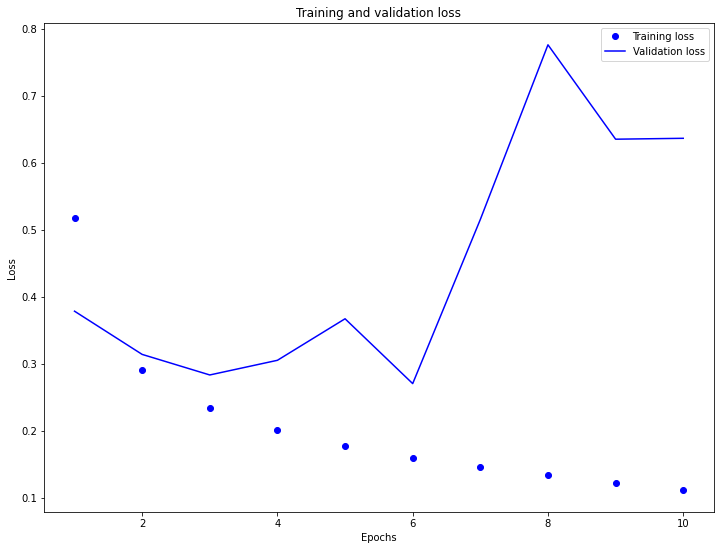

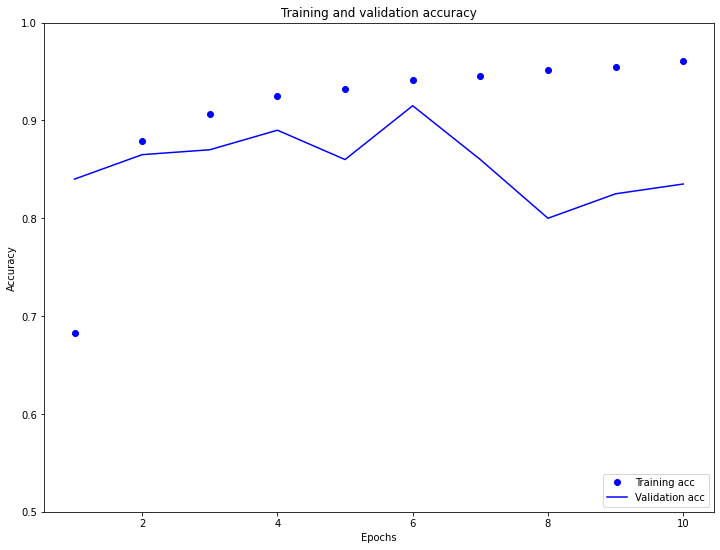

In [11]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

Next, let's retrieve the word embeddings learned during training. This will be a matrix of shape (vocab_size, embedding-dimension).

In [12]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


In [13]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [14]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

http://projector.tensorflow.org/